## Objective:
Build a hybrid model of CNN and LSTM to classify the Meetei Mayek (Manipuri) characters..

Import all necessary libraries

In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random

from PIL import Image
from tqdm import tqdm
from PIL import Image
from shutil import copyfile,rmtree
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout, LSTM, Input, Reshape, concatenate, TimeDistributed, MaxPooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix


Mounting the google drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
output_folder='/content/output'
if os.path.exists(output_folder):
    rmtree(output_folder)

In [8]:
folder='/content/drive/MyDrive/mmdb_400'

Unicode format of Meetei Mayek characters..

References: [Google Fonts](https://fonts.google.com/noto/specimen/Noto+Sans+Meetei+Mayek/glyphs?query=Meetei)

In [10]:
characters=[
    (0xABF0, "DIGIT ZERO", 0),
    (0xABF1, "DIGIT ONE", 1),
    (0xABF2, "DIGIT TWO", 2),
    (0xABF3, "DIGIT THREE", 3),
    (0xABF4, "DIGIT FOUR", 4),
    (0xABF5, "DIGIT FIVE", 5),
    (0xABF6, "DIGIT SIX", 6),
    (0xABF7, "DIGIT SEVEN", 7),
    (0xABF8, "DIGIT EIGHT", 8),
    (0xABF9, "DIGIT NINE", 9),
    (0xABC0, "LETTER KOK", 10),
    (0xABC1, "LETTER SAM", 11),
    (0xABC2, "LETTER LAI", 12),
    (0xABC3, "LETTER MIT", 13),
    (0xABC4, "LETTER PA", 14),
    (0xABC5, "LETTER NA", 15),
    (0xABC6, "LETTER CHIL", 16),
    (0xABC7, "LETTER TIL", 17),
    (0xABC8, "LETTER KHOU", 18),
    (0xABC9, "LETTER NGOU", 19),
    (0xABCA, "LETTER THOU", 20),
    (0xABCB, "LETTER WAI", 21),
    (0xABCC, "LETTER YANG", 22),
    (0xABCD, "LETTER HUK", 23),
    (0xABCE, "LETTER UN", 24),
    (0xABCF, "LETTER I", 25),
    (0xABD0, "LETTER PHAM", 26),
    (0xABD1, "LETTER ATIYA", 27),
    (0xABD2, "LETTER GOK", 28),
    (0xABD3, "LETTER JHAM", 29),
    (0xABD4, "LETTER RAI", 30),
    (0xABD5, "LETTER BA", 31),
    (0xABD6, "LETTER JIL", 32),
    (0xABD7, "LETTER DIL", 33),
    (0xABD8, "LETTER GHOU", 34),
    (0xABD9, "LETTER DHOU", 35),
    (0xABDA, "LETTER BHAM", 36),
    (0xABDB, "LETTER KOK LONSUM", 37),
    (0xABDC, "LETTER LAI LONSUM", 38),
    (0xABDD, "LETTER MIT LONSUM", 39),
    (0xABDE, "LETTER PA LONSUM", 40),
    (0xABDF, "LETTER NA LONSUM", 41),
    (0xABE0, "LETTER TIL LONSUM", 42),
    (0xABE1, "LETTER NGOU LONSUM", 43),
    (0xABE2, "LETTER I LONSUM", 44),
    (0xABE3, "VOWEL SIGN ONAP", 45),
    (0xABE4, "VOWEL SIGN INAP", 46),
    (0xABE5, "VOWEL SIGN ANAP", 47),
    (0xABE6, "VOWEL SIGN YENAP", 48),
    (0xABE7, "VOWEL SIGN SOUNAP", 49),
    (0xABE8, "VOWEL SIGN UNAP", 50),
    (0xABE9, "VOWEL SIGN CHEINAP", 51),
    (0xABEA, "VOWEL SIGN NUNG", 52),
    (0xABEB, "CHEIKHEI", 53),
    (0xABEC, "LUM IYEK", 54),
    (0xABED, "APUN IYEK", 55)
]


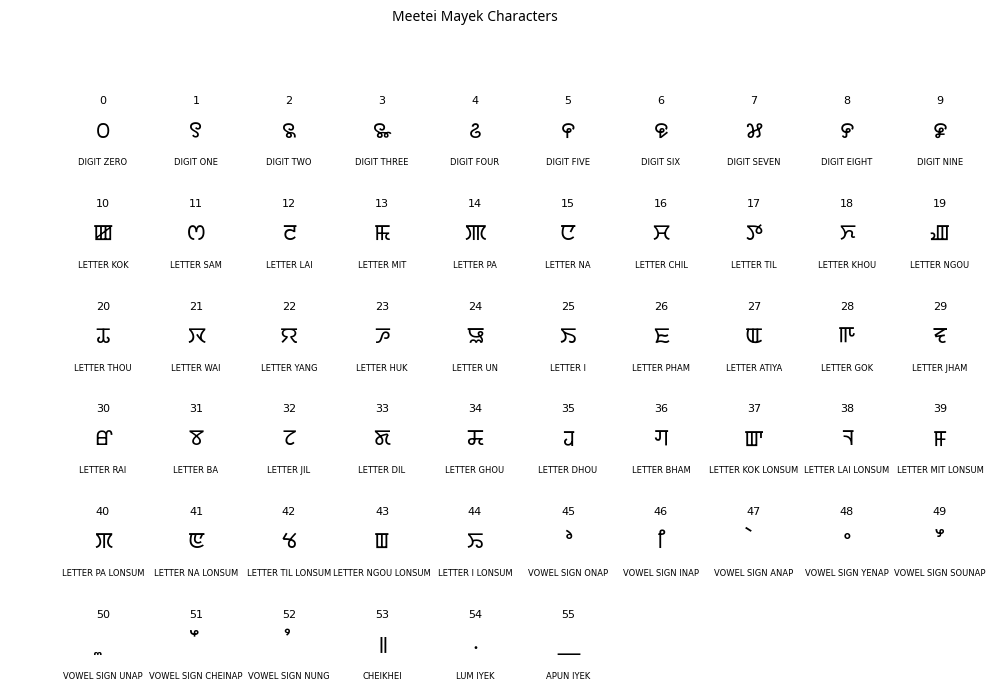

In [11]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = "/content/drive/MyDrive/font styles/regular.ttf"
prop = fm.FontProperties(fname=font_path)
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Meetei Mayek Characters", fontproperties=prop)
ax.set_xlim(0, 10)
ax.set_ylim(0, len(characters) // 10 + 1)
ax.axis("off")

for i, (unicode_val, name,index) in enumerate(characters):
    row = i//10
    col = i%10+1
    ax.text(col, len(characters) // 10 - row + 0.3, index, fontsize=8, ha="center", va="center")
    ax.text(col, len(characters) // 10 - row, chr(unicode_val), fontproperties=prop, fontsize=16, ha="center", va="center")
    ax.text(col, len(characters) // 10 - row - 0.3, name, fontsize=6, ha="center", va="center")
plt.show()


## Data Visualization

It's time to visualize the image data.

Choose a random class (0-55): 4


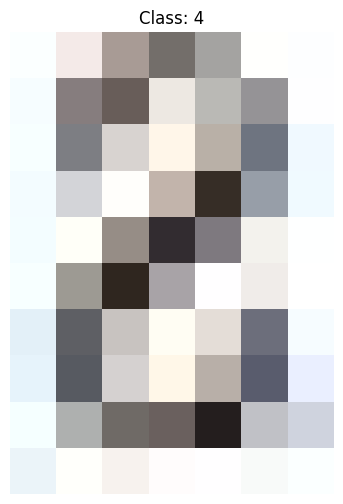

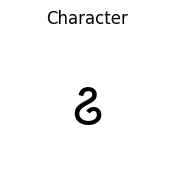

In [ ]:
random_class = input('Choose a random class (0-55): ')
class_folder = os.path.join(folder, random_class)
random_image = random.choice(os.listdir(class_folder))
image_path = os.path.join(class_folder, random_image)
image = load_img(image_path)


plt.figure(figsize=(6,6))
plt.imshow(image)
plt.title(f"Class: {random_class}")
plt.axis('off')
plt.show()
fig, ax = plt.subplots(figsize=(2,2))
ax.set_title("Character")
ax.text(0.5, 0.5, chr(characters[int(random_class)][0]), fontproperties=prop, fontsize=40, ha="center", va="center")
ax.axis('off')
plt.show()

## Data preprocessing

Create separate train and test folders with the image data in a ratio of 80:20

In [12]:
output_folder='/content/output'

def copy_images(class_folder, output_folder, num_train=360, num_test=40):
    image_list=os.listdir(class_folder)
    random.shuffle(image_list)

    train_folder=os.path.join(output_folder, 'train', os.path.basename(class_folder))
    test_folder=os.path.join(output_folder, 'test', os.path.basename(class_folder))

    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    for i, image_name in tqdm(enumerate(image_list), desc=f"Copying {os.path.basename(class_folder)}"):
        image_path=os.path.join(class_folder, image_name)
        if i < num_train:
            output_path=os.path.join(train_folder, image_name)
            copyfile(image_path, output_path)
        elif i < num_train + num_test:
            output_path=os.path.join(test_folder, image_name)
            copyfile(image_path, output_path)
        else:
            break
for class_name in os.listdir(folder):
    class_folder=os.path.join(folder, class_name)
    copy_images(class_folder, output_folder)
print("\nData Copying completed.")


Copying 52: 400it [00:08, 44.65it/s] 
Copying 55: 400it [00:06, 64.80it/s] 
Copying 6: 400it [00:07, 51.91it/s] 
Copying 54: 400it [00:10, 38.11it/s] 
Copying 50: 400it [00:06, 63.80it/s] 
Copying 9: 400it [00:06, 58.41it/s] 
Copying 51: 400it [00:07, 50.04it/s] 
Copying 7: 400it [00:09, 42.08it/s] 
Copying 8: 400it [00:06, 62.90it/s] 
Copying 53: 400it [00:05, 67.55it/s] 
Copying 49: 400it [00:07, 54.72it/s] 
Copying 42: 400it [00:08, 45.21it/s] 
Copying 46: 400it [00:10, 36.69it/s] 
Copying 47: 400it [00:06, 62.62it/s] 
Copying 5: 400it [00:06, 62.60it/s] 
Copying 48: 400it [00:09, 41.54it/s] 
Copying 45: 400it [00:07, 51.52it/s] 
Copying 44: 400it [00:06, 63.64it/s] 
Copying 43: 400it [00:07, 53.53it/s] 
Copying 41: 400it [00:05, 68.31it/s] 
Copying 33: 400it [00:07, 51.33it/s] 
Copying 36: 400it [00:07, 54.77it/s] 
Copying 40: 400it [00:09, 42.78it/s] 
Copying 34: 400it [00:10, 38.57it/s] 
Copying 32: 400it [00:08, 49.76it/s] 
Copying 37: 400it [00:07, 53.92it/s] 
Copying 39: 400it


Data Copying completed.


In [13]:
train_folder=output_folder+'/train'
test_folder=output_folder+'/test'

Shuffle the images within the folder to make model to learn complex patterns

In [14]:
def get_files_and_labels(root_folder):
    image_paths = []
    labels = []
    for label_idx, label_folder in enumerate(sorted(os.listdir(root_folder))):
        label_path = os.path.join(root_folder, label_folder)
        for image_file in sorted(os.listdir(label_path)):
            image_paths.append(os.path.join(label_path, image_file))
            labels.append(label_idx)
    combined = list(zip(image_paths, labels))
    random.shuffle(combined)
    image_paths[:], labels[:] = zip(*combined)

    return image_paths, labels

We are resizing the images to 30x30 since they are not in a fixed size, and we are making them all the same size.

In [15]:
def resize_images(image_paths, target_size=(30, 30)):
    resized_images = []
    for image_path in image_paths:
        image = Image.open(image_path)
        resized_image = image.resize(target_size)
        resized_images.append(resized_image)
    return resized_images

In [16]:
train_image_paths, train_labels = get_files_and_labels(train_folder)
test_image_paths, test_labels = get_files_and_labels(test_folder)

In [17]:
resized_train_images = resize_images(train_image_paths)
resized_test_images = resize_images(test_image_paths)

print("Train samples:", len(resized_train_images))
print("Test samples:", len(resized_test_images))
print("Train labels:", train_labels[:5])
print("Test labels:", test_labels[:5])

Train samples: 20160
Test samples: 2240
Train labels: [52, 22, 1, 41, 3]
Test labels: [10, 3, 51, 40, 19]


In [18]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

print("Shape of train_labels_array:", train_labels.shape)
print("Shape of test_labels_array:", test_labels.shape)

Shape of train_labels_array: (20160,)
Shape of test_labels_array: (2240,)


In [ ]:
ind=4
print(f"Label: {train_labels[ind]}")
resized_train_images[ind]

Label: 1


In [ ]:
ind=1
print(f"Label: {test_labels[ind]}")
resized_test_images[ind]

Label: 53


Flattening the train and test data

In [19]:
def resize_and_array(image_paths, target_size=(30, 30)):
    arrays = []
    for image_path in image_paths:
        image = Image.open(image_path)
        image = image.resize(target_size)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        array = np.array(image) / 255.0
        arrays.append(array)
    return np.array(arrays)

In [20]:
train_image_arrays = resize_and_array(train_image_paths)
test_image_arrays = resize_and_array(test_image_paths)

print("Shape of train_image_arrays:", train_image_arrays.shape)
print("Shape of test_image_arrays:", test_image_arrays.shape)

Shape of train_image_arrays: (20160, 30, 30, 3)
Shape of test_image_arrays: (2240, 30, 30, 3)


In [21]:
x_train,y_train,x_test,y_test=train_image_arrays,train_labels,test_image_arrays,test_labels

In [22]:
x_train = np.array(x_train).reshape(len(x_train),1,30,30, 3)
x_test= np.array(x_test).reshape(len(x_test),1,30,30, 3)

In [23]:
print("x_train:",x_train.shape)
print("Train labels:",y_train.shape)
print("x_test:",x_test.shape)
print("Test labels:",y_test.shape)

x_train: (20160, 1, 30, 30, 3)
Train labels: (20160,)
x_test: (2240, 1, 30, 30, 3)
Test labels: (2240,)


## Model

In [ ]:
model = Sequential()
model.add(TimeDistributed(Conv2D(64,(3,3),activation='relu'),input_shape=(1,30,30,3)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model.add(TimeDistributed(Conv2D(64,(3,3),activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model.add(TimeDistributed(Conv2D(32,(3,3),activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=False))

model.add(Dense(56,activation='softmax'))

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_59 (TimeD  (None, 1, 28, 28, 64)     1792      
 istributed)                                                     
                                                                 
 time_distributed_60 (TimeD  (None, 1, 14, 14, 64)     0         
 istributed)                                                     
                                                                 
 time_distributed_61 (TimeD  (None, 1, 12, 12, 64)     36928     
 istributed)                                                     
                                                                 
 time_distributed_62 (TimeD  (None, 1, 6, 6, 64)       0         
 istributed)                                                     
                                                                 
 time_distributed_63 (TimeD  (None, 1, 4, 4, 32)     

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

Training the model..

In [ ]:
history = model.fit(x_train,y_train,epochs = 25,validation_data = (x_test, y_test),shuffle=True,batch_size=32)

Epoch 1/25
630/630 [==============================] - 7s 6ms/step - loss: 1.5448 - acc: 0.6456 - val_loss: 0.6384 - val_acc: 0.8518
Epoch 2/25
630/630 [==============================] - 4s 6ms/step - loss: 0.4357 - acc: 0.8950 - val_loss: 0.3981 - val_acc: 0.9004
Epoch 3/25
630/630 [==============================] - 4s 6ms/step - loss: 0.2796 - acc: 0.9304 - val_loss: 0.2893 - val_acc: 0.9237
Epoch 4/25
630/630 [==============================] - 3s 5ms/step - loss: 0.2038 - acc: 0.9486 - val_loss: 0.2581 - val_acc: 0.9317
Epoch 5/25
630/630 [==============================] - 3s 5ms/step - loss: 0.1620 - acc: 0.9588 - val_loss: 0.2140 - val_acc: 0.9388
Epoch 6/25
630/630 [==============================] - 4s 6ms/step - loss: 0.1315 - acc: 0.9660 - val_loss: 0.1797 - val_acc: 0.9482
Epoch 7/25
630/630 [==============================] - 3s 5ms/step - loss: 0.1099 - acc: 0.9713 - val_loss: 0.1760 - val_acc: 0.9464
Epoch 8/25
630/630 [==============================] - 3s 5ms/step - loss: 0.

Plotting the metrics

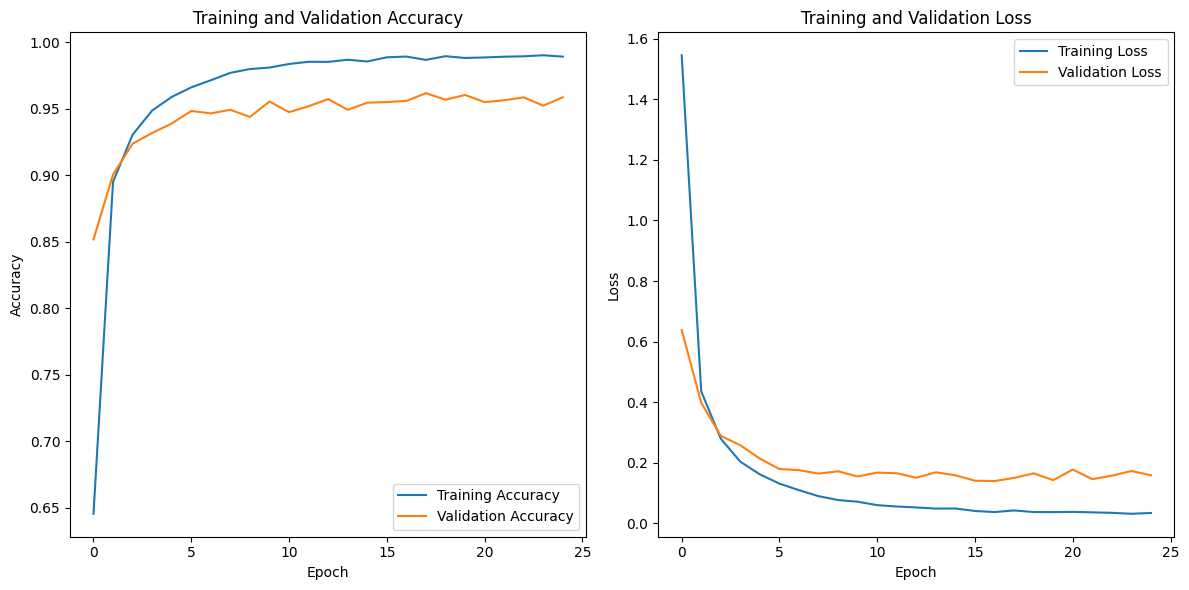

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Predicting and Classification report

In [ ]:
predictions = model.predict(x_test)
pred=np.argmax(predictions,axis=1)
pred = pred.reshape(1,-1)[0]
print(classification_report(y_test,pred, target_names = [str(i) for i in range(56)]))

70/70 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        40
           1       0.97      0.93      0.95        40
           2       1.00      0.97      0.99        40
           3       1.00      0.95      0.97        40
           4       1.00      1.00      1.00        40
           5       1.00      0.93      0.96        40
           6       1.00      0.93      0.96        40
           7       0.98      1.00      0.99        40
           8       0.79      0.95      0.86        40
           9       1.00      1.00      1.00        40
          10       0.97      0.97      0.97        40
          11       1.00      1.00      1.00        40
          12       0.97      0.82      0.89        40
          13       1.00      1.00      1.00        40
          14       0.93      0.70      0.80        40
          15       0.97      0.95      0.96        40
          16       0.95     

Evaluating the model's performance

In [ ]:
model.evaluate(x_test,y_test,batch_size=32)

70/70 [==============================] - 0s 3ms/step - loss: 0.1591 - acc: 0.9585


[0.15913192927837372, 0.9584821462631226]

Saving the model for future use

In [ ]:
model.save('cnn_lstm_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
from google.colab import files
files.upload()

Saving cnn_lstm_model.h5 to cnn_lstm_model.h5


{'cnn_lstm_model.h5': b'\x89HDF\r\n\x1a\n\x00\x00\x00\x00\x00\x08\x08\x00\x04\x00\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\x88-\x1d\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00`\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x88\x00\x00\x00\x00\x00\x00\x00\xa8\x02\x00\x00\x00\x00\x00\x00\x01\x00\x06\x00\x01\x00\x00\x00\x18\x00\x00\x00\x00\x00\x00\x00\x10\x00\x10\x00\x00\x00\x00\x00 \x03\x00\x00\x00\x00\x00\x00P\x01\x00\x00\x00\x00\x00\x00TREE\x00\x00\x01\x00\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00\x00(\x00\x00\x00\x00\x00\x00\x18\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

Loading the model

In [ ]:
model=tf.keras.models.load_model('cnn_lstm_model.h5')
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_59 (TimeD  (None, 1, 28, 28, 64)     1792      
 istributed)                                                     
                                                                 
 time_distributed_60 (TimeD  (None, 1, 14, 14, 64)     0         
 istributed)                                                     
                                                                 
 time_distributed_61 (TimeD  (None, 1, 12, 12, 64)     36928     
 istributed)                                                     
                                                                 
 time_distributed_62 (TimeD  (None, 1, 6, 6, 64)       0         
 istributed)                                                     
                                                                 
 time_distributed_63 (TimeD  (None, 1, 4, 4, 32)     